In [2]:
import numpy as np
import pandas as pd
import torch

from torch.utils.data import DataLoader
from torchviz import make_dot

from nba_betting_ai.consts import proj_paths
from nba_betting_ai.deploy.inference_bayesian import download_model_to, load_model, run_inference, prepare_experiment, calculate_probs_for_diff
from nba_betting_ai.model.inputs import scale_data
from nba_betting_ai.training.dataset import NBADataset
from nba_betting_ai.training.pipeline import prepare_data

In [1]:
model_uri = """
mlflow-artifacts:/664344747479239756/e483524e3e6c405da7dc25abca8aabfb/artifacts/bayesian_model-20250211-235348-774.pth
""".strip()


In [5]:
# wpaths = download_model_to(w_model_uri)
# w_model, w_scalers, w_team_features, w_config = load_model(*wpaths)
# w_scalers.pop('final_score_diff', None)
nwpaths = download_model_to(model_uri)
nw_model, nw_scalers, nw_team_features, nw_config = load_model(*nwpaths)
nw_scalers.pop('final_score_diff', None)

StandardScaler(with_mean=False)

In [5]:
data_prepared = prepare_data(**w_config['data_params'])

train_dataset = NBADataset(w_config['inputs_team'], w_config['target'], data_prepared.X_train, data_prepared.teams, w_scalers)
test_dataset = NBADataset(w_config['inputs_team'], w_config['target'], data_prepared.X_test, data_prepared.teams, w_scalers)

params = w_config['training']['params']
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

NameError: name 'w_config' is not defined

In [6]:
data = next(iter(test_loader))
y = data.pop('y')



probs_w, mu_w, std_w = run_inference(w_model, data)
probs_nw, mu_nw, std_nw = run_inference(nw_model, data)

weights = (0.5 - 0.5*data['time_remaining']/data['time_remaining'].max()).detach().numpy().flatten()
probs = weights*probs_w + (1-weights)*probs_nw




In [9]:
viz = make_dot(output_w, params=dict(w_model.named_parameters()))
viz.graph_attr.update(rankdir='LR')
viz.render(filename=proj_paths.models / w_config['model_name'], format='png')
viz

NameError: name 'output_w' is not defined

In [7]:
df = pd.DataFrame(dict(
    time_remaining = w_scalers['time_remaining'].inverse_transform(data['time_remaining'].reshape(-1, 1)).flatten(),
    diff = w_scalers['score_diff'].inverse_transform(data['diff'].reshape(-1, 1)).flatten(),
    home = data['home_team'].flatten(),
    away = data['away_team'].flatten(),
    probs = probs
))

In [8]:
df.sort_values(by=['home', 'away', 'time_remaining'])[:50]

,time_remaining,diff,home,away,probs
99,21.0,-16.0,4,2,0.783592
98,175.0,-4.0,4,2,0.546256
97,739.0,-6.0,4,2,0.613954
96,987.0,-1.0,4,2,0.515263
95,1064.0,-2.0,4,2,0.542127
94,1205.0,-5.0,4,2,0.615407
93,1267.0,-9.0,4,2,0.699019
92,1526.0,-7.0,4,2,0.673270
91,1542.0,-5.0,4,2,0.633943
90,1938.0,-14.0,4,2,0.810988


In [7]:
data_params = {
    'seasons': 1,
    'seed': 0,
    'test_size': 1.0,
    'n': None,
    'frac': 1.0,
}
data_prepared = prepare_data(**data_params)
X = data_prepared.X_test
teams = data_prepared.teams
team_encoder = dict(zip(teams['abbreviation'], teams.index))


In [8]:
data_params = {
    'seasons': 1,
    'seed': 0,
    'test_size': 1.0,
    'n': None,
    'frac': 1.0,
}
data_prepared = prepare_data(**data_params)
X = data_prepared.X_test
teams = data_prepared.teams
team_encoder = dict(zip(teams['abbreviation'], teams.index))


abbrev_away = 'CHI'
abbrev_home = 'CHI'
score_diff = -5
experiment = prepare_experiment(abbrev_home, abbrev_away, score_diff, X.copy(), teams) 
results = calculate_probs_for_diff(abbrev_home, abbrev_away, experiment, w_model, nw_model, w_scalers, nw_scalers, w_config, nw_config, team_encoder)


In [ ]:
# Find the newest file in the directory: proj_paths.pg_dump


1737545025.2198257

In [14]:
results['probs']

0       0.714321
1       0.714274
2       0.714228
3       0.714181
4       0.714134
          ...   
2876    0.605319
2877    0.605303
2878    0.605287
2879    0.605271
2880    0.605255
Name: probs, Length: 2881, dtype: float64

<Axes: >

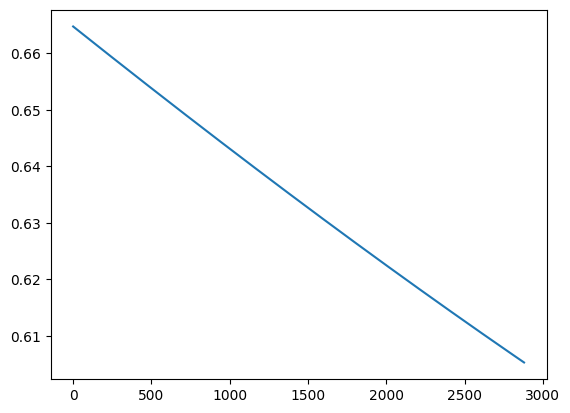

In [7]:
results['probs_w'].plot()

In [11]:
results['time_remaining']

0          0.0
1          1.0
2          2.0
3          3.0
4          4.0
         ...  
2876    2876.0
2877    2877.0
2878    2878.0
2879    2879.0
2880    2880.0
Name: time_remaining, Length: 2881, dtype: float64

In [10]:
teams['abbreviation']

team_no
0     ATL
1     BOS
2     CLE
3     NOP
4     CHI
5     DAL
6     DEN
7     GSW
8     HOU
9     LAC
10    LAL
11    MIA
12    MIL
13    MIN
14    BKN
15    NYK
16    ORL
17    IND
18    PHI
19    PHX
20    POR
21    SAC
22    SAS
23    OKC
24    TOR
25    UTA
26    MEM
27    WAS
28    DET
29    CHA
Name: abbreviation, dtype: object